In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
from pathlib import Path
from numpy import arange
from configparser import ConfigParser
from scipy.constants import speed_of_light, c
import warnings
import copy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [2]:
def file_is_empty(path):
    if os.path.exists(path):
        if os.stat(path).st_size==0:
            return False
        else:
            return True
    else:
        return False

In [3]:
def defineLimits(Ydata, HighLimit, LowLimit):
    i=0
    for i in arange(0, Ydata.shape[0], 1):
        if Ydata[i]<LowLimit:
            Ydata[i]=LowLimit
        if Ydata[i]>HighLimit:
            Ydata[i]=HighLimit
        i+=1

In [4]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

In [5]:
def percentage(part, whole):
#   return 100 * float(part)/float(whole)
    return float(part)/float(whole)

In [6]:
def FindMAXin2D(field):
    ind_max = np.unravel_index(np.argmax(field, axis=None), field.shape)
    return field[ind_max]

In [7]:
def FindMINin2D(field):    
    ind_min = np.unravel_index(np.argmin(field, axis=None), field.shape)
    return field[ind_max]

In [8]:
def cfg_get(cfg_path, block, param):
    cfg = ConfigParser()
    cfg.read(cfg_path)
    param = cfg.get(block, param)
    param = param.split('\t')
    if param[0].isdigit():
        param = int(param[0])
    else:
        param = float(param[0])
    return param

In [9]:
def checkDet(data, delta):
    mean = np.mean(data)
    for i in range(0, len(data)):
        if abs(data[i] - mean) > delta:
            return True
    return False

In [10]:
def checkBlock(data, dataBegin, dataEnd):
    counter = 0
    mean = np.mean(data)
    for i in range(0, len(data)):
        if data[i] >= dataBegin and data[i] <= dataEnd:
            counter = counter+1
    return counter

In [11]:
def checkBlockTable(data, dataBegin, dataEnd):
    counter = 0
    mean = np.mean(data)
    for i in range(0, len(data)):
        if data[i] >= dataBegin and data[i] <= dataEnd:
            counter = counter+1
    return counter

In [12]:
ARC_F_perf  = True        # plot ARK on field
CF_F_perf   = True        # plot CF on field
SD_F_perf   = True        # plot SD on fieldLocation_DetFField_Axes
FTAU_F_perf = True        # plot FTAU on field
IgnoreWarnings = True

Running...

Experiment 1
T_ARC: bad
T_CF: good
T_SD: good
Completed. Plotting results...


(array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 19 Text xticklabel objects>)

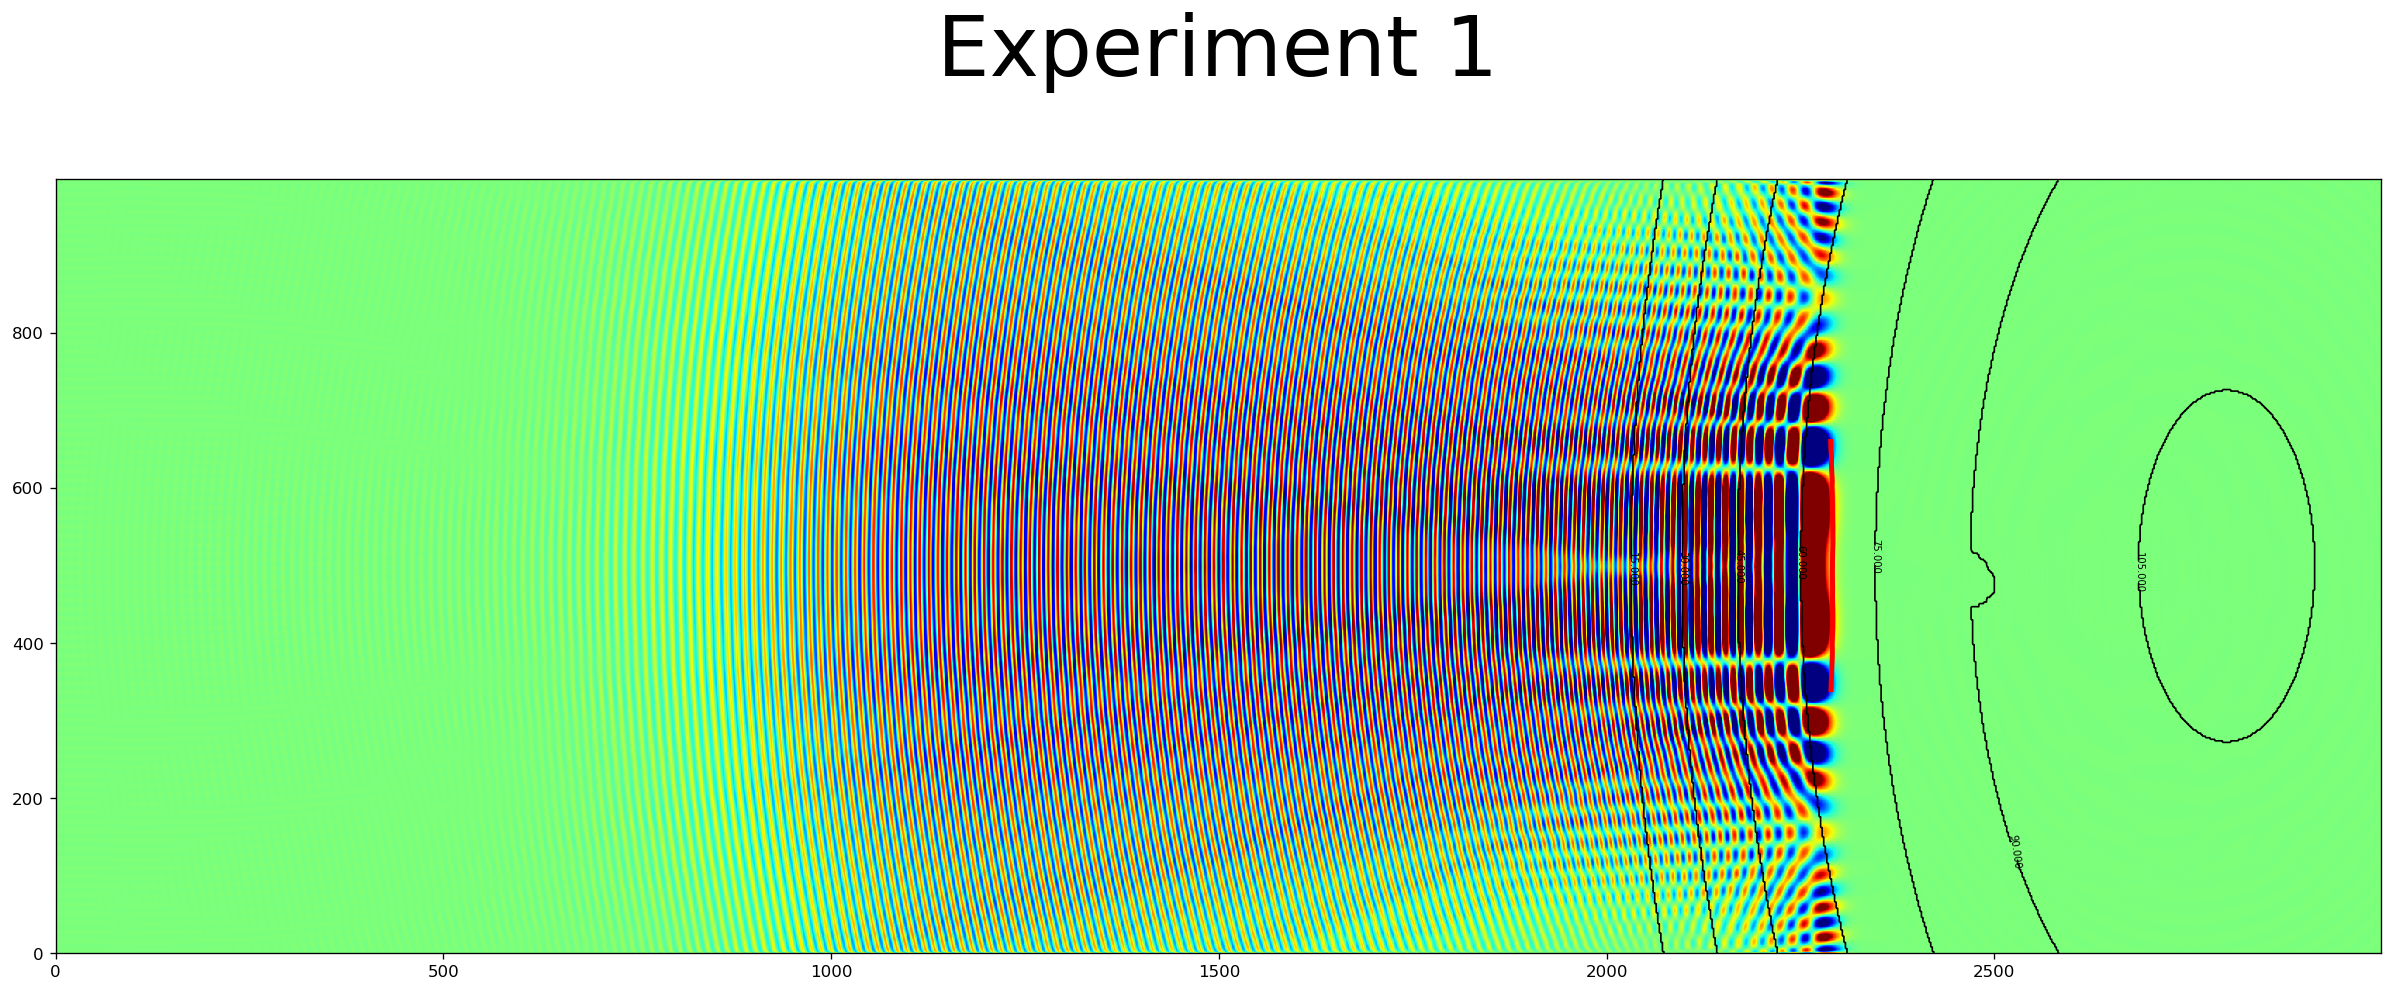

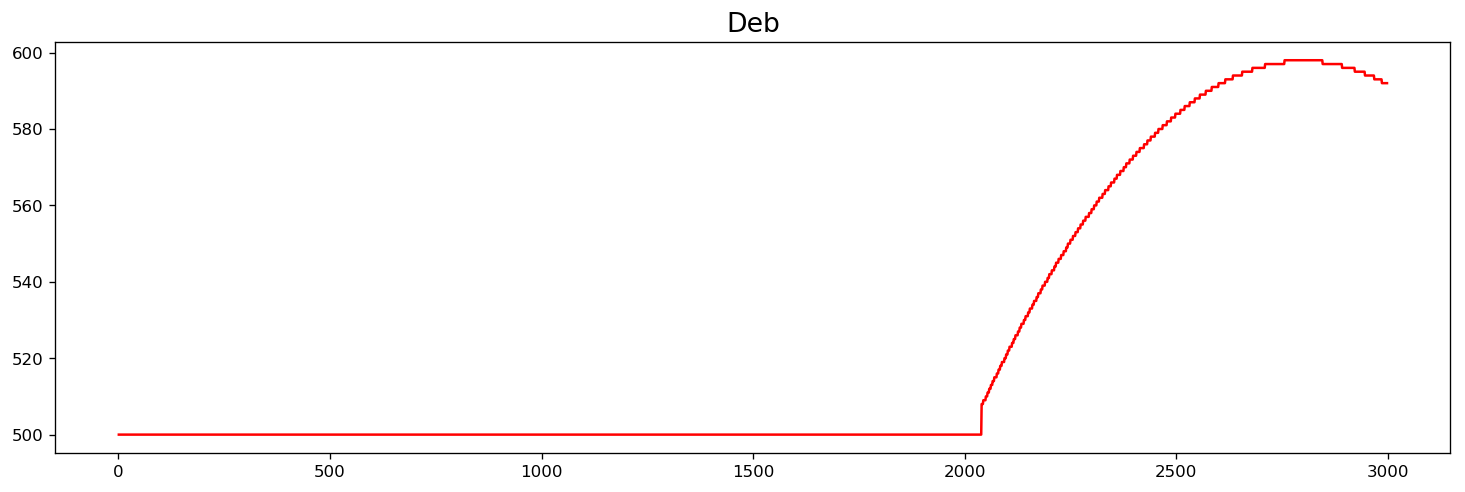

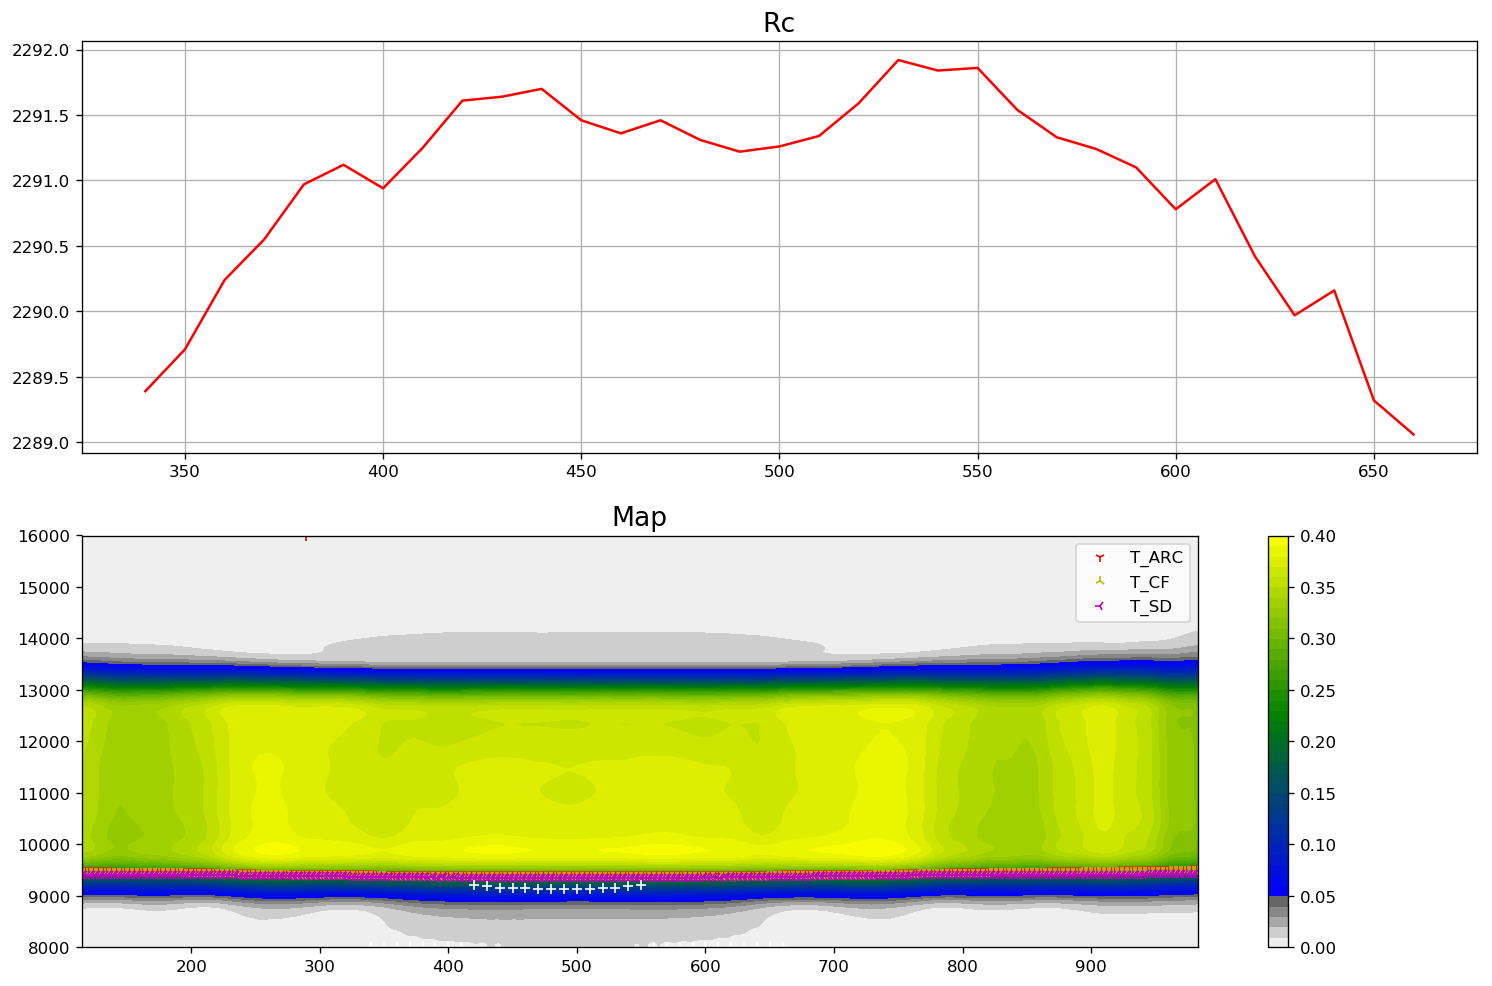

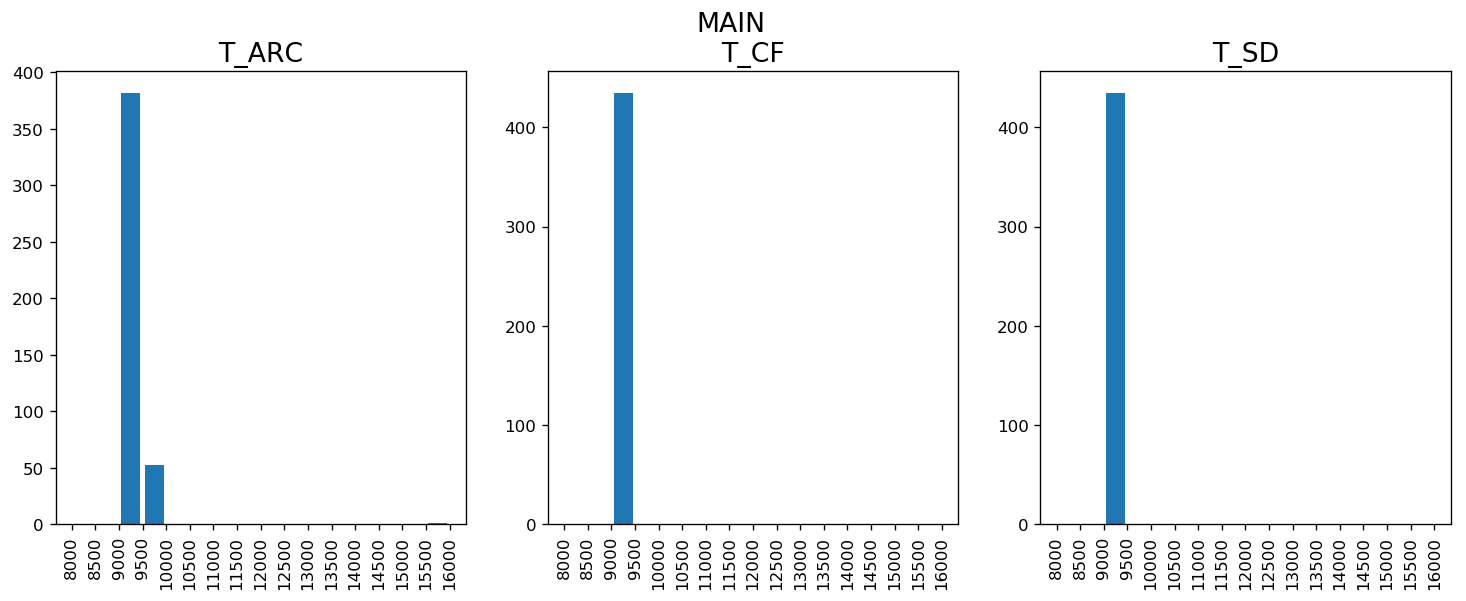

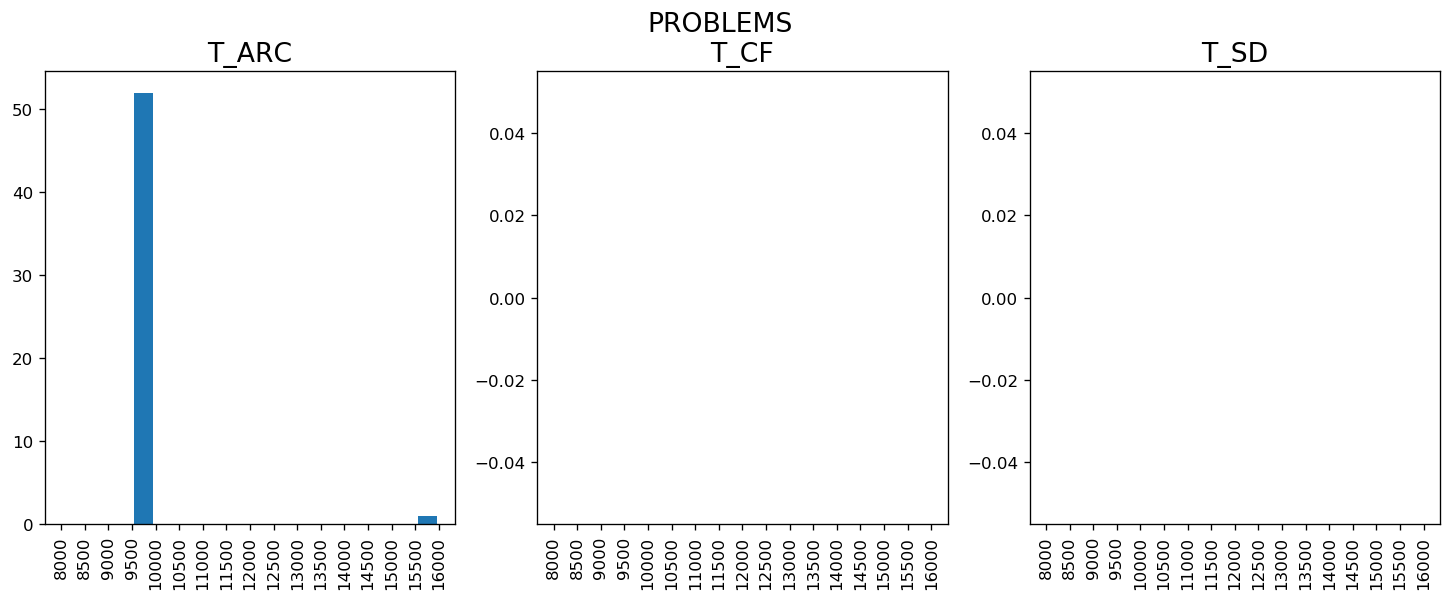

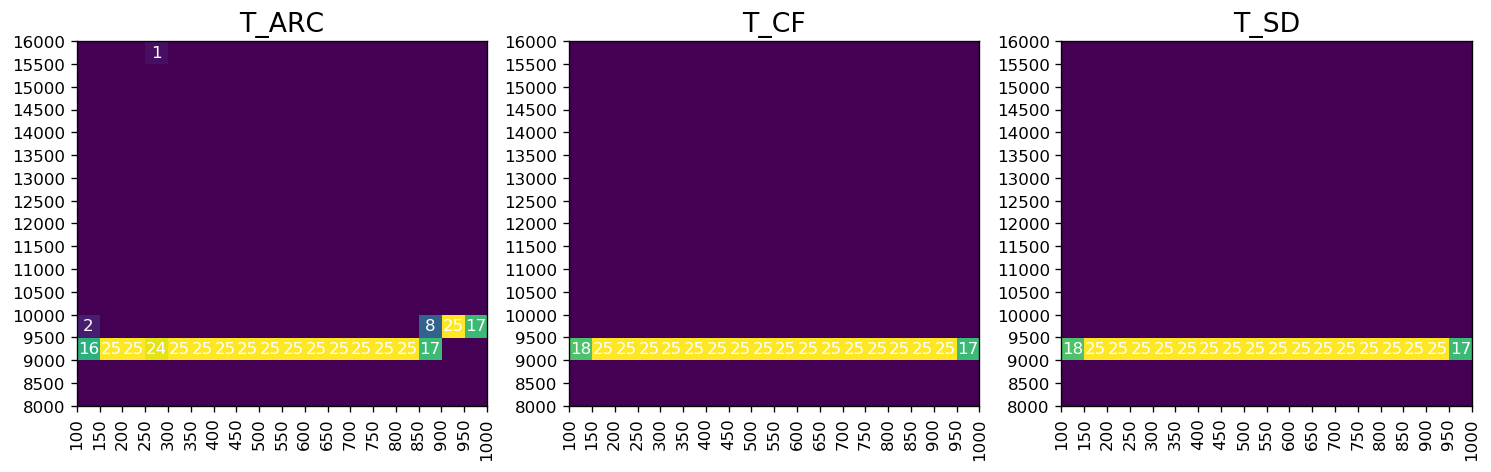

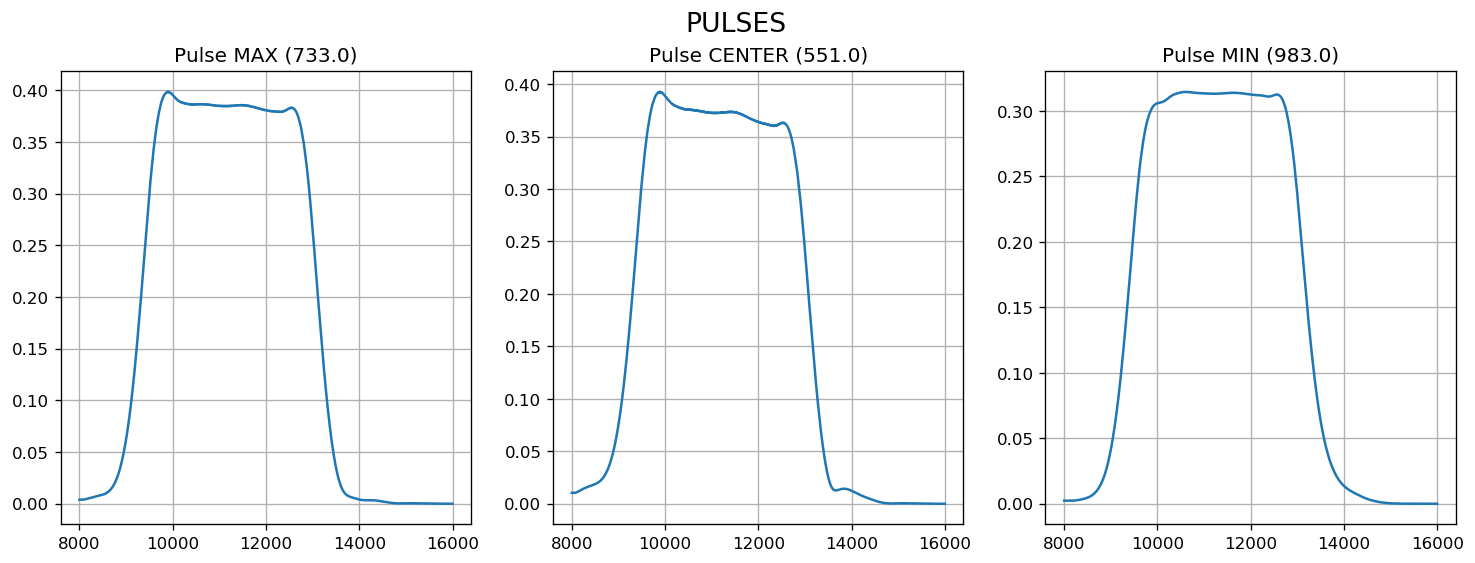

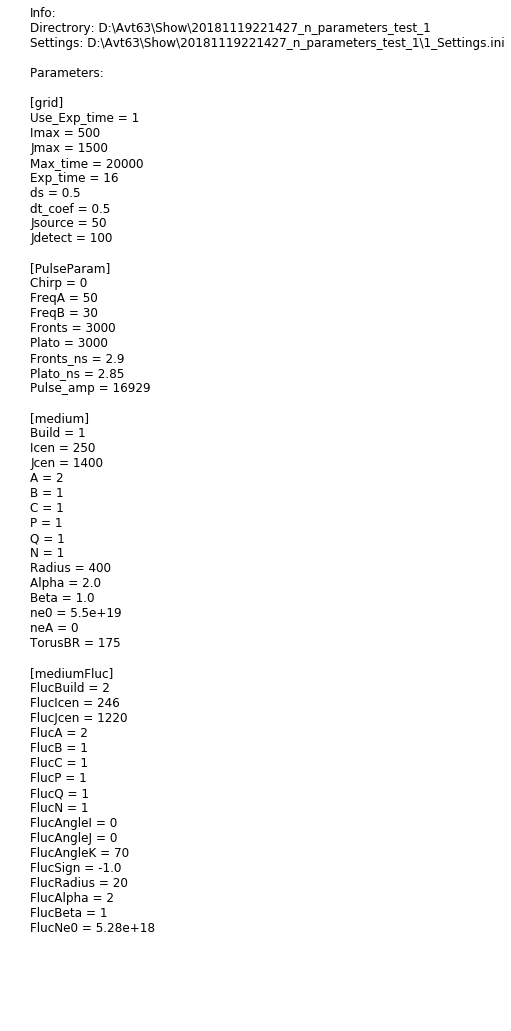

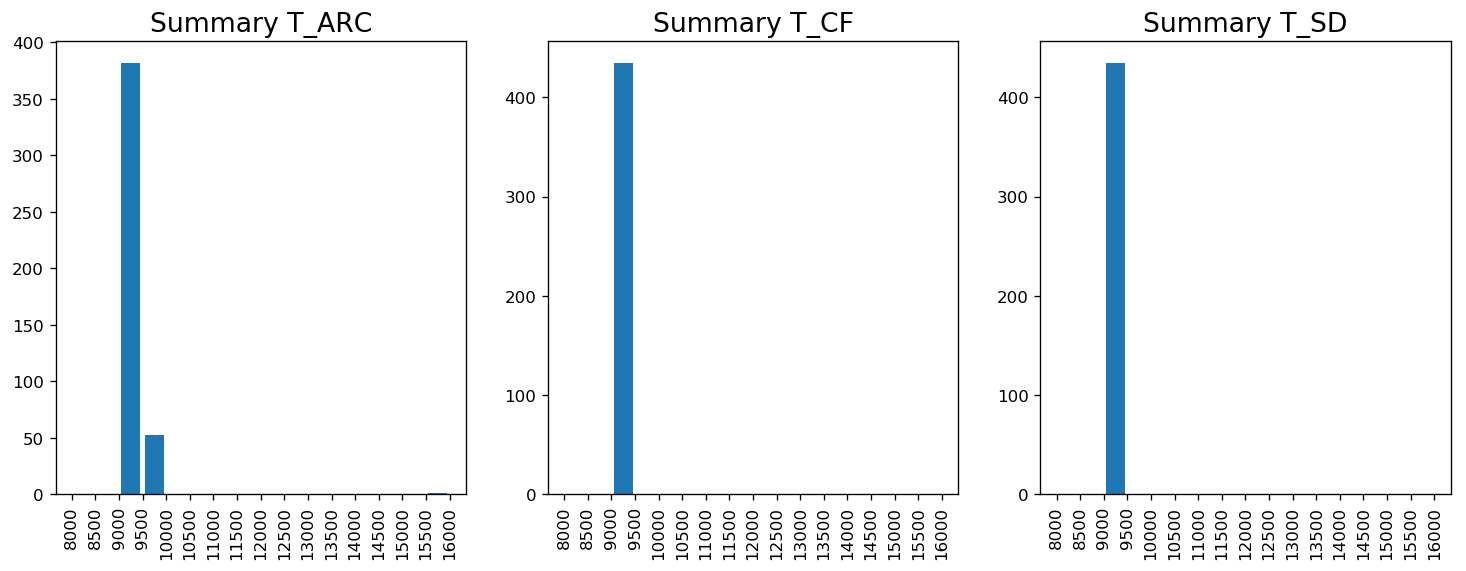

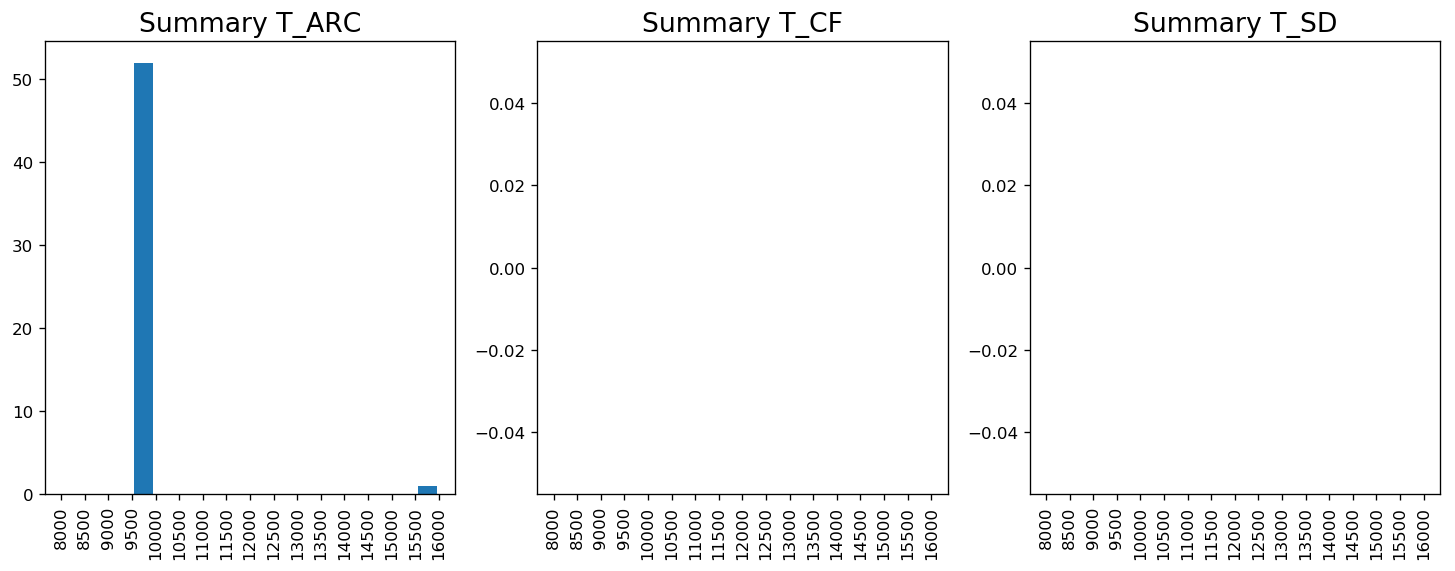

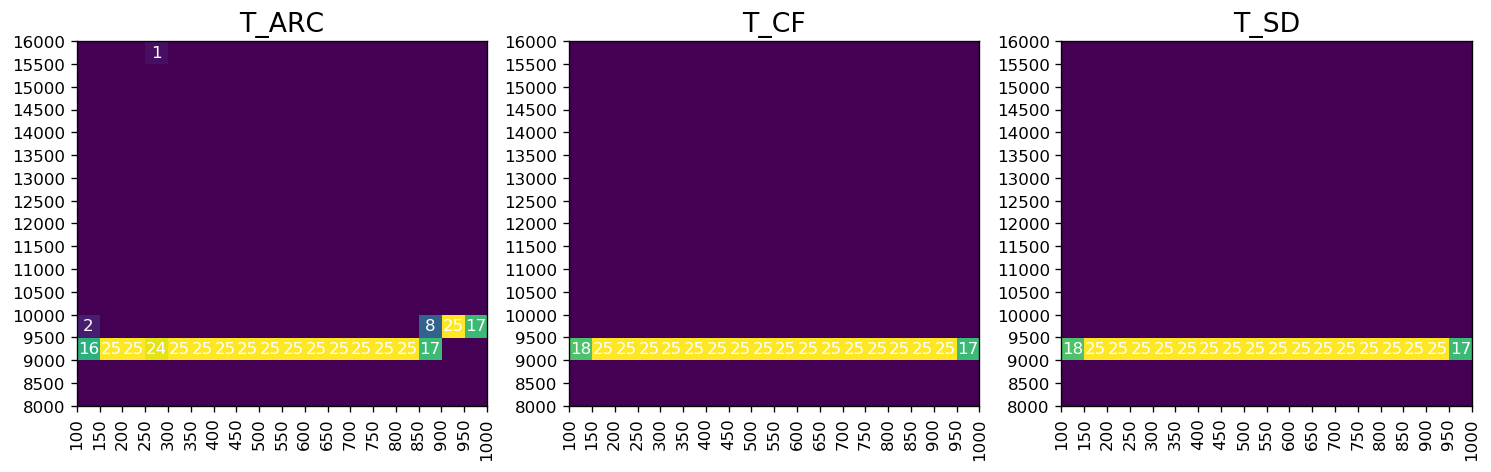

In [13]:
# ---------------------OPTIONS-----------------------------------
directory      = 'D:\\Avt63\\Show'
P_cutOff_level = 0.05
TimeSlise      = 0
LowLim         = -25
HighLim        = 25
PCounturPlot   = True
ExpNumber      = 0
delta          = 1000
Det_time_step  = 500
Det_time_step_x = 50 
# ---------------------------------------------------------------- 

if IgnoreWarnings:
    warnings.filterwarnings("ignore")
tree = os.walk(directory, topdown = False)
print("Running...")

ErrFlag = False
FirstIteration = True
for address, dirs, files in tree:
    directory = Path(address)
    count = 1
    index_max = 1
    while True:
        if (len(files)-count) >= 0:
            index = files[len(files)-count]
        else:
            index = 0
            break
        index = index.split('_')
        index = index[0]
        count = count + 1
        if index.isdigit() == False:
            continue
        index_max = max(index_max, int(index))
        
    for index in range(1, int(index_max)+1):
        ErrFlag = False
        index = str(index)
    
        Location_DetFField = directory / (index + "_detector_filtered_field.txt")
        Location_DetFField_Axes = directory / (index + "_detector_filtered_field_Axis.txt")
        Location_Deb_data = directory / (index + "_deb.txt")
        Location_DetARC = directory / (index + "_det_ARC.txt")
        Location_DetCF = directory / (index + "_det_CF.txt")
        Location_DetSD = directory / (index + "_det_SD.txt")
        Location_fieldTAU = directory / (index + "_TAU_Line.txt")
        Location_RC_pos = directory / (index + "_RcDet_data.txt")
        Location_RC_data = directory / (index + "_RC_Line.txt")
        Location_Srv = directory / (index + "_FieldSaveDat.txt")
        Location_Data = directory / (index + "_Ez.txt")
        cfg_path = directory / (index + "_Settings.ini")

        DetFField_exist = file_is_empty(Location_DetFField)
        DetFField_Axes_exist = file_is_empty(Location_DetFField_Axes)
        DEBexist = file_is_empty(Location_Deb_data) 
        ARC_exist = file_is_empty(Location_DetARC) 
        CF_exist = file_is_empty(Location_DetCF) 
        SD_exist = file_is_empty(Location_DetSD) 
        FTAU_exist = file_is_empty(Location_fieldTAU) 
        RC_pos_exist = file_is_empty(Location_RC_pos) 
        RC_exist = file_is_empty(Location_RC_data)
        
        if DEBexist == False:
            continue
        
        # ---------------------------------
        # Getting parameters from Settings.ini
        
        #[grid]
        Use_Exp_time = cfg_get(cfg_path, 'grid', 'Use_Exp_time')
        Imax = cfg_get(cfg_path, 'grid', 'Imax')
        Jmax = cfg_get(cfg_path, 'grid', 'Jmax')
        Max_time = cfg_get(cfg_path, 'grid', 'Max_time')
        Exp_time = cfg_get(cfg_path, 'grid', 'Exp_time')
        ds = cfg_get(cfg_path, 'grid', 'ds')
        dt_coef = cfg_get(cfg_path, 'grid', 'dt_coef')
        source_pos = cfg_get(cfg_path, 'grid', 'Jsource')
        detect_pos = cfg_get(cfg_path, 'grid', 'Jdetect')
        
        #[PulseParam]
        Chirp = cfg_get(cfg_path, 'PulseParam', 'Chirp')
        FreqA = cfg_get(cfg_path, 'PulseParam', 'FreqA')
        FreqB = cfg_get(cfg_path, 'PulseParam', 'FreqB')
        Fronts = cfg_get(cfg_path, 'PulseParam', 'Fronts')
        Plato = cfg_get(cfg_path, 'PulseParam', 'Plato')
        Fronts_ns = cfg_get(cfg_path, 'PulseParam', 'Fronts_ns')
        Plato_ns = cfg_get(cfg_path, 'PulseParam', 'Plato_ns')
        Pulse_amp = cfg_get(cfg_path, 'PulseParam', 'Pulse_amp')
        
        #[medium]
        Build = cfg_get(cfg_path, 'medium', 'Build')
        Icen = cfg_get(cfg_path, 'medium', 'Icen')
        Jcen = cfg_get(cfg_path, 'medium', 'Jcen')
        A = cfg_get(cfg_path, 'medium', 'A')
        B = cfg_get(cfg_path, 'medium', 'B')
        C = cfg_get(cfg_path, 'medium', 'C')     
        P = cfg_get(cfg_path, 'medium', 'P')
        Q = cfg_get(cfg_path, 'medium', 'Q')
        N = cfg_get(cfg_path, 'medium', 'N')         
        Radius = cfg_get(cfg_path, 'medium', 'Radius')
        Alpha = cfg_get(cfg_path, 'medium', 'Alpha')
        Beta = cfg_get(cfg_path, 'medium', 'Beta')
        ne0 = cfg_get(cfg_path, 'medium', 'ne0')
        neA = cfg_get(cfg_path, 'medium', 'neA')
        TorusBR = cfg_get(cfg_path, 'medium', 'TorusBR')
        
        #[mediumFluc]
        FlucBuild = cfg_get(cfg_path, 'mediumFluc', 'FlucBuild')
        FlucIcen = cfg_get(cfg_path, 'mediumFluc', 'FlucIcen')
        FlucJcen = cfg_get(cfg_path, 'mediumFluc', 'FlucJcen')
        FlucA = cfg_get(cfg_path, 'mediumFluc', 'FlucA')
        FlucB = cfg_get(cfg_path, 'mediumFluc', 'FlucB')
        FlucC = cfg_get(cfg_path, 'mediumFluc', 'FlucC')                      
        FlucP = cfg_get(cfg_path, 'mediumFluc', 'FlucP')
        FlucQ = cfg_get(cfg_path, 'mediumFluc', 'FlucQ')
        FlucN = cfg_get(cfg_path, 'mediumFluc', 'FlucN')
        FlucAngleI = cfg_get(cfg_path, 'mediumFluc', 'FlucAngleI')
        FlucAngleJ = cfg_get(cfg_path, 'mediumFluc', 'FlucAngleJ')
        FlucAngleK = cfg_get(cfg_path, 'mediumFluc', 'FlucAngleK')
        FlucSign = cfg_get(cfg_path, 'mediumFluc', 'FlucSign')                      
        FlucRadius = cfg_get(cfg_path, 'mediumFluc', 'FlucRadius')
        FlucAlpha = cfg_get(cfg_path, 'mediumFluc', 'FlucAlpha')
        FlucBeta = cfg_get(cfg_path, 'mediumFluc', 'FlucBeta')
        FlucNe0 = cfg_get(cfg_path, 'mediumFluc', 'FlucNe0')
        
        # ---------------------------------
        corr_coef = ((abs(detect_pos - source_pos)/1000)/c)*1e12

        ExpNumber = ExpNumber + 1
    # ---------------------------------
        # read service information from FDTD core, need for get data
        service_inf = np.loadtxt(Location_Srv, delimiter=' ', dtype=np.int)
        data = pd.read_csv(Location_Data, delim_whitespace=True, header=None)
        data = data.values

        # get size of calculated field
        x_s = int(service_inf[0])
        y_s = int(data.shape[1])
        z_s = int(service_inf[1])

        # Create 3D array for FDTD data
        FrameData = np.zeros((x_s, y_s, z_s))

        # alignment raw data into frames
        i=0
        while i < z_s :
            try:
                FrameData[:,:,i] = data[(x_s*i) : (x_s*(i+1)), :]
            except ValueError:
                ErrFlag = True
                break
            i=i+1          
        if ErrFlag:
            print('ValueError: Experiment ' + str(ExpNumber))
            print('Path: ' + str(directory))
            print('Index: ' + str(index))
            print('Alpha: ' + str(Alpha) + '    Beta: ' + str(Beta))
            print('\n')
            continue
            
        #create grid for colormap
        y_bound, x_bound = np.mgrid[slice(0, x_s+1, 1),
                                    slice(0, y_s+1, 1)]

    # ---------------------------------
        if DetFField_exist & DetFField_Axes_exist:
            DetFField = pd.read_csv(Location_DetFField, delim_whitespace=True, header=None)
            DetFField = DetFField.values

            DetFAxes = pd.read_csv(Location_DetFField_Axes, delim_whitespace=True, header=None)
            DetFAxes = DetFAxes.values

            DetFAxisX = DetFAxes[2,0:DetFField.shape[1]]
            DetFAxisY = DetFAxes[0,0:DetFField.shape[0]]

    # -----------------------------------------------------------------------
        T_ARC_Err = False
        T_CF_Err = False
        T_SD_Err = False
        
        if ARC_exist & ARC_F_perf:
            T_ARC = pd.read_csv(Location_DetARC, delim_whitespace=True, header=None)
            T_ARC = T_ARC.values
            defineLimits(T_ARC[:,3], DetFAxisY[DetFAxisY.shape[0]-1], DetFAxisY[0])
            T_ARC_Err = checkDet(T_ARC[:,3], delta)

        if CF_exist & CF_F_perf:
            T_CF = pd.read_csv(Location_DetCF, delim_whitespace=True, header=None)
            T_CF = T_CF.values
            defineLimits(T_CF[:,3], DetFAxisY[DetFAxisY.shape[0]-1], DetFAxisY[0])
            T_CF_Err = checkDet(T_CF[:,3], delta)

        if SD_exist & SD_F_perf:
            T_SD = pd.read_csv(Location_DetSD, delim_whitespace=True, header=None)
            T_SD = T_SD.values
            defineLimits(T_SD[:,3], DetFAxisY[DetFAxisY.shape[0]-1], DetFAxisY[0])
            T_SD_Err = checkDet(T_SD[:,3], delta)
        # -----------------------------------------------------------------------
        print('\nExperiment ' + str(ExpNumber))
        if T_ARC_Err:
            print('T_ARC: bad')
        else:
            print('T_ARC: good')
        if T_CF_Err:
            print('T_CF: bad')
        else:
            print('T_CF: good')
        if T_SD_Err:
            print('T_SD: bad')
        else:
            print('T_SD: good')
        if(T_ARC_Err == False and T_CF_Err == False and T_SD_Err == False):
            continue
        #print('Path: ' + str(directory))
        #print(Location_Srv)
        #print('Alpha: ' + str(alpha) + '    Beta: ' + str(BetaBegin+step*beta-step))
        #print('\n')
    # -------------------------------------------------------------------   
        if FTAU_exist & RC_pos_exist & RC_exist:
            T_Field = pd.read_csv(Location_fieldTAU, delim_whitespace=True, header=None)
            T_Field = T_Field.values

            RC_pos = pd.read_csv(Location_RC_pos, delim_whitespace=True, header=None)
            RC_pos=RC_pos.loc[0,:]

            RC_data = np.loadtxt(Location_RC_data, delimiter=' ', dtype=np.float)

            T_Field[:,1]=T_Field[:,1]-corr_coef
            defineLimits(T_Field[:,1], DetFAxisY[DetFAxisY.shape[0]-1], DetFAxisY[0])

        if DetFField_exist & DetFField_Axes_exist:
            try:
                P_cutOff_perc = percentage(P_cutOff_level, FindMAXin2D(DetFField)) 
            except ZeroDivisionError:
                print('ZeroDivisionError: ' + 'Experiment ' + str(ExpNumber))
                print('Expression: P_cutOff_perc = percentage(P_cutOff_level, FindMAXin2D(DetFField))')
                print('Path: ' + str(directory))
                print('Index: ' + str(index))
                print('Alpha: ' + str(Alpha) + '    Beta: ' + str(Beta))
                print('\n')
                continue
            P_mid = ((1.0-P_cutOff_perc)/2)+P_cutOff_perc
            cc = mcolors.ColorConverter().to_rgb
            rvb = make_colormap(
            [cc('#FFFFFF'), cc('#505050A9'), P_cutOff_perc, cc('blue'), cc('green'), P_mid, cc('green'), cc('yellow'), 1.0, cc('yellow')])

        if(DEBexist and PCounturPlot == True):
            dataDeb = pd.read_csv(Location_Deb_data, delim_whitespace=True, header=None)
            dataDeb = dataDeb.values
        
        if(RC_exist):
            RC_data = np.loadtxt(Location_RC_data, delimiter=' ', dtype=np.float)
            RC_pos = pd.read_csv(Location_RC_pos, delim_whitespace=True, header=None)
            RC_pos=RC_pos.loc[0,:]
            
        #Определение границ для графиков
        Det_time_begin = int(round(DetFAxisY[0]/Det_time_step)*Det_time_step)
        Det_time_end   = int(round(DetFAxisY[len(DetFAxisY)-1]/Det_time_step)*Det_time_step)
        Det_time_num = int((Det_time_end-Det_time_begin)/Det_time_step)
        Det_time_x_begin = int(round(DetFAxisX[0]/Det_time_step_x)*Det_time_step_x)
        Det_time_x_end = int(round(DetFAxisX[len(DetFAxisX)-1]/Det_time_step_x)*Det_time_step_x)
        Det_time_num_x = int((Det_time_x_end-Det_time_x_begin)/Det_time_step_x)
        
        #Выделение памяти
        if FirstIteration == True:
            Det_time_summary = np.zeros((3,Det_time_num), dtype=int)
            Det_time_summary_problems = np.zeros((3,Det_time_num), dtype=int)
            if ARC_F_perf == True:
                Det_time_summary_table_ARC = np.zeros((Det_time_num,Det_time_num_x), dtype=int)
            if CF_F_perf == True:
                Det_time_summary_table_CF = np.zeros((Det_time_num,Det_time_num_x), dtype=int)
            Det_time_summary_table_SD = np.zeros((Det_time_num,Det_time_num_x), dtype=int)
        Det_time = np.zeros((3,Det_time_num), dtype=int)
        Det_time_problem = np.zeros((3,Det_time_num), dtype=int)
        if ARC_F_perf == True:
            Det_time_table_ARC = np.zeros((Det_time_num,Det_time_num_x), dtype=int)
        if CF_F_perf == True:
            Det_time_table_CF = np.zeros((Det_time_num,Det_time_num_x), dtype=int)
        Det_time_table_SD = np.zeros((Det_time_num,Det_time_num_x), dtype=int)
        
        #Получение данных для общих диаграмм    
        Det_pr = Det_time_begin
        if((len(T_ARC[:,0]) == len(T_CF[:,0])) and (len(T_ARC[:,0]) == len(T_SD[:,0]))): 
            for i in range(0, Det_time_num):
                if ARC_F_perf == True:
                    Det_time[0,i] = checkBlock(T_ARC[:,3], Det_pr, Det_pr+Det_time_step)
                if CF_F_perf == True:
                    Det_time[1,i] = checkBlock(T_CF[:,3], Det_pr, Det_pr+Det_time_step)
                Det_time[2,i] = checkBlock(T_SD[:,3], Det_pr, Det_pr+Det_time_step)
                if ARC_F_perf == True:
                    Det_time_problem[0,i] = Det_time[0,i]
                if CF_F_perf == True:
                    Det_time_problem[1,i] = Det_time[1,i]
                Det_time_problem[2,i] = Det_time[2,i]
                Det_pr = Det_pr+Det_time_step
        
        #Получение данных для диаграмм с ошибками
        for i in range(0,3):
            Det_time_max = max(Det_time[i])
            for j in range(0,Det_time_num):
                if(Det_time_problem[i,j] == Det_time_max):
                    Det_time_problem[i,j] = 0
                
        #Получение данных для табличных диаграмм       
        for i in range(0, len(T_ARC[:,0])):
            if ARC_F_perf == True:
                Det_time_table_ARC[int(T_ARC[i,3]/Det_time_step)-int(Det_time_begin/Det_time_step),int(T_ARC[i,0]/Det_time_step_x)-int(Det_time_x_begin/Det_time_step_x)] += 1
            if CF_F_perf == True:
                Det_time_table_CF[int(T_CF[i,3]/Det_time_step)-int(Det_time_begin/Det_time_step),int(T_CF[i,0]/Det_time_step_x)-int(Det_time_x_begin/Det_time_step_x)] += 1
            Det_time_table_SD[int(T_SD[i,3]/Det_time_step)-int(Det_time_begin/Det_time_step),int(T_SD[i,0]/Det_time_step_x)-int(Det_time_x_begin/Det_time_step_x)] += 1

        #Получение суммарных результатов
        Det_time_summary = Det_time_summary + Det_time
        Det_time_summary_problems = Det_time_summary_problems + Det_time_problem
        if ARC_F_perf == True:
            Det_time_summary_table_ARC = Det_time_summary_table_ARC + Det_time_table_ARC
        if CF_F_perf == True:
            Det_time_summary_table_CF = Det_time_summary_table_CF + Det_time_table_CF
        Det_time_summary_table_SD = Det_time_summary_table_SD + Det_time_table_SD
        
        # -------------------------------------------------------------------  
        #Create figure and axis for plotting
        #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

        fig  = plt.figure(figsize=(25, 20), dpi= 120)
        ax   = plt.subplot(111)
        ax.set_title('Experiment ' + str(ExpNumber) + '\n', fontsize = 50)
        cax = ax.pcolormesh(x_bound, y_bound, FrameData[:,:,TimeSlise], vmin=LowLim, vmax=HighLim, cmap = 'jet')

        if(DEBexist and PCounturPlot == True):
            #plt.figure()  manual=manual_locations
            manual_locations = [(8, 10), (20, 25), (50, 55), (70, 75), (90, 95), (120, 125), (140, 150)]
            y_bound_d, x_bound_d = np.mgrid[slice(0, x_s, 1),
                                        slice(0, y_s, 1)]
            CS = ax.contour(x_bound_d, y_bound_d, dataDeb, colors='k', linewidths=1)
            plt.clabel(CS, fontsize=6, inline=1)
            

        ax.set_aspect('equal', 'box')

        if(RC_exist):
            ax.plot(RC_data[:,1], RC_pos, 'r', linewidth = 3)
        
        if DEBexist:
            fig = plt.figure(figsize=(15, 10), dpi= 120)
            axM = plt.subplot(211)
            axM.set_title('Deb', fontsize=16)
            dataDebSize = len(dataDeb)-1
            axM.plot(range(1,len(dataDeb[dataDebSize,:])+1), dataDeb[dataDebSize,:]+Imax/2/ds, 'r')
    # -------------------------------------------------------------------  
    #plot Map
        if DetFField_exist & DetFField_Axes_exist:
            fig = plt.figure(figsize=(15, 10), dpi= 120)
            axM = plt.subplot(212)
            axM.set_title('Map', fontsize=16)
    #     Y_side=np.arange(0, DetFField.shape[0], 1)
            cF=axM.contourf(DetFAxisX, DetFAxisY, DetFField, 40, cmap=rvb)
            #csO = plt.contourf(DetOField)
            fig.colorbar(cF)

            # ARC tau detection method
            if ARC_exist & ARC_F_perf:         
                 p_ARC = axM.plot(T_ARC[:,0], T_ARC[:,3],'r1')
                    
            # ARC tau detection method
            if CF_exist & CF_F_perf:         
                 p_CF = axM.plot(T_CF[:,0], T_CF[:,3],'y2')
                    
            # ARC tau detection method
            if SD_exist & SD_F_perf:         
                 p_SD = axM.plot(T_SD[:,0], T_SD[:,3],'m3')

            # ARC tau detection method
            if FTAU_exist & RC_pos_exist & FTAU_F_perf:         
                p_FTAU = axM.plot(RC_pos, T_Field[:,1],'w+')
            
            axM.legend((p_ARC[0], p_CF[0], p_SD[0]), ('T_ARC', 'T_CF', 'T_SD'))
    # -------------------------------------------------------------------

        if RC_exist & RC_pos_exist: 
            axR = plt.subplot(211)
            axR.plot(RC_pos, RC_data[:,1], 'r')
            plt.grid(True)
            axR.set_title('Rc', fontsize = 16)
    # -------------------------------------------------------------------
    #plot bars
            fig = plt.figure(figsize=(15, 5), dpi= 120)
            if ARC_F_perf == True:
                axB1 = fig.add_subplot(131)
                axB1.set_title('T_ARC', fontsize=16)
                axB1.bar(range(int((Det_time_begin+Det_time_step)/Det_time_step),int((Det_time_end+Det_time_step)/Det_time_step)), Det_time[0,:]) 
                axB1.set_xticks(np.arange((Det_time_begin+0.5*Det_time_step)/Det_time_step,int((Det_time_end+Det_time_step)/Det_time_step), 1))
                axB1.set_xticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
                plt.xticks(rotation=90)
                
            if CF_F_perf == True:
                axB2 = fig.add_subplot(132)
                axB2.set_title('T_CF', fontsize=16)
                axB2.bar(range(int((Det_time_begin+Det_time_step)/Det_time_step),int((Det_time_end+Det_time_step)/Det_time_step)), Det_time[1,:]) 
                axB2.set_xticks(np.arange((Det_time_begin+0.5*Det_time_step)/Det_time_step,int((Det_time_end+Det_time_step)/Det_time_step), 1))
                axB2.set_xticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
                plt.xticks(rotation=90)
            
            axB3 = fig.add_subplot(133)
            axB3.set_title('T_SD', fontsize=16)
            axB3.bar(range(int((Det_time_begin+Det_time_step)/Det_time_step),int((Det_time_end+Det_time_step)/Det_time_step)), Det_time[2,:]) 
            axB3.set_xticks(np.arange((Det_time_begin+0.5*Det_time_step)/Det_time_step,int((Det_time_end+Det_time_step)/Det_time_step), 1))
            axB3.set_xticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
            plt.xticks(rotation=90)
            plt.suptitle('MAIN', fontsize=16)
            
            fig = plt.figure(figsize=(15, 5), dpi= 120)
            #axB1 = plt.subplot(413)
            if ARC_F_perf == True:
                axB1 = fig.add_subplot(131)
                axB1.set_title('T_ARC', fontsize=16)
                axB1.bar(range(int((Det_time_begin+Det_time_step)/Det_time_step),int((Det_time_end+Det_time_step)/Det_time_step)), Det_time_problem[0,:]) 
                axB1.set_xticks(np.arange((Det_time_begin+0.5*Det_time_step)/Det_time_step,int((Det_time_end+Det_time_step)/Det_time_step), 1))
                axB1.set_xticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
                plt.xticks(rotation=90)
            
            if CF_F_perf == True:
                axB2 = fig.add_subplot(132)
                axB2.set_title('T_CF', fontsize=16)
                axB2.bar(range(int((Det_time_begin+Det_time_step)/Det_time_step),int((Det_time_end+Det_time_step)/Det_time_step)), Det_time_problem[1,:]) 
                axB2.set_xticks(np.arange((Det_time_begin+0.5*Det_time_step)/Det_time_step,int((Det_time_end+Det_time_step)/Det_time_step), 1))
                axB2.set_xticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
                plt.xticks(rotation=90)
            #fig = plt.figure(figsize=(15, 10), dpi= 120)
            #axB3 = plt.subplot(413)
            axB3 = fig.add_subplot(133)
            axB3.set_title('T_SD', fontsize=16)
            axB3.bar(range(int((Det_time_begin+Det_time_step)/Det_time_step),int((Det_time_end+Det_time_step)/Det_time_step)), Det_time_problem[2,:]) 
            axB3.set_xticks(np.arange((Det_time_begin+0.5*Det_time_step)/Det_time_step,int((Det_time_end+Det_time_step)/Det_time_step), 1))
            axB3.set_xticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
            plt.xticks(rotation=90)
            plt.suptitle('PROBLEMS', fontsize=16)
    #axB1.xticks(x, ('Bill', 'Fred', 'Mary', 'Sue'))
    # -------------------------------------------------------------------
        
        fig = plt.figure(figsize=(15, 15), dpi= 120)
        if ARC_F_perf == True:
            ax1 = fig.add_subplot(131)
            ax1.set_xticks(np.arange(-.5, Det_time_num_x, 1))
            ax1.set_yticks(np.arange(-.5, Det_time_num, 1))
            ax1.set_xticklabels(np.arange(Det_time_x_begin, Det_time_x_end+Det_time_step_x, Det_time_step_x))
            ax1.set_yticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
            ax1.imshow(Det_time_table_ARC, origin="lower")
            ax1.set_title('T_ARC', fontsize=16)
            for i, j in zip(*Det_time_table_ARC.nonzero()):
                ax1.text(j, i, Det_time_table_ARC[i, j], color='white', ha='center', va='center')
            plt.xticks(rotation=90)
            
        if CF_F_perf == True:
            ax2 = fig.add_subplot(132)
            ax2.set_xticks(np.arange(-.5, Det_time_num_x, 1))
            ax2.set_yticks(np.arange(-.5, Det_time_num, 1))
            ax2.set_xticklabels(np.arange(Det_time_x_begin, Det_time_x_end+Det_time_step_x, Det_time_step_x))
            ax2.set_yticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
            ax2.imshow(Det_time_table_CF, origin="lower")
            ax2.set_title('T_CF', fontsize=16)
            for i, j in zip(*Det_time_table_CF.nonzero()):
                ax2.text(j, i, Det_time_table_CF[i, j], color='white', ha='center', va='center')
            plt.xticks(rotation=90)
        
        ax3 = fig.add_subplot(133)
        ax3.set_xticks(np.arange(-.5, Det_time_num_x, 1))
        ax3.set_yticks(np.arange(-.5, Det_time_num, 1))
        ax3.set_xticklabels(np.arange(Det_time_x_begin, Det_time_x_end+Det_time_step_x, Det_time_step_x))
        ax3.set_yticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
        ax3.imshow(Det_time_table_SD, origin="lower")
        for i, j in zip(*Det_time_table_SD.nonzero()):
            ax3.text(j, i, Det_time_table_SD[i, j], color='white', ha='center', va='center')
        ax3.set_title('T_SD', fontsize=16)
        plt.xticks(rotation=90)
        #plt.suptitle('diag', fontsize=16)
    
    # -------------------------------------------------------------------
        if DetFField_exist & DetFField_Axes_exist:
            ind_max = np.unravel_index(np.argmax(DetFField, axis=None), DetFField.shape)
            ind_min = np.unravel_index(np.argmin(DetFField[ind_max[0],:], axis=None), DetFField.shape)
    #     print(ind_max, DetFField[ind_max])
    #     print(ind_min, DetFField[ind_min])

            fig2 = plt.figure(figsize=(15, 5), dpi= 120)
            #fig2.autofmt_xdate()
    #     fig2.canvas.set_window_title('My title')    
            axT1 = plt.subplot(131)
            cT1=axT1.plot(DetFAxisY, DetFField[:,ind_max[1]])
            plt.title('Pulse MAX (' + str(DetFAxisX[ind_max[1]]) + ')')  
            plt.grid(True)

            axT2 = plt.subplot(132)
            cT2=axT2.plot(DetFAxisY, DetFField[:,round(DetFField.shape[1]/2)])
            plt.title('Pulse CENTER (' + str(DetFAxisX[round(DetFField.shape[1]/2)]) + ')' )
            plt.grid(True)

            axT3 = plt.subplot(133)
            cT3=axT3.plot(DetFAxisY, DetFField[:,ind_min[1]])
            plt.title('Pulse MIN (' + str(DetFAxisX[ind_min[1]]) + ')')
            plt.grid(True)

            plt.suptitle('PULSES', fontsize=16)
                        
            fig3 = plt.figure(figsize=(1, 1), frameon = False)
            axT4 = plt.subplot(111)
            axT4.axis('off')
            axT4.set_title('Info:\n'
                           'Directrory: '+ str(directory) + '\n' +
                           'Settings: ' + str(cfg_path) + '\n\n' +
                           'Parameters: \n\n' + 
                           '[grid]\n' +
                           'Use_Exp_time = ' + str(Use_Exp_time) + '\n' +
                           'Imax = ' + str(Imax) + '\n' +
                           'Jmax = ' + str(Jmax) + '\n' +
                           'Max_time = ' + str(Max_time) + '\n' +
                           'Exp_time = ' + str(Exp_time) + '\n' +
                           'ds = ' + str(ds) + '\n' +
                           'dt_coef = ' + str(dt_coef) + '\n' +
                           'Jsource = ' + str(source_pos) + '\n' +
                           'Jdetect = ' + str(detect_pos) + '\n\n' +
                           '[PulseParam]\n' +
                           'Chirp = ' + str(Chirp) + '\n' +
                           'FreqA = ' + str(FreqA) + '\n' +
                           'FreqB = ' + str(FreqB) + '\n' +
                           'Fronts = ' + str(Fronts) + '\n' +
                           'Plato = ' + str(Plato) + '\n' +
                           'Fronts_ns = ' + str(Fronts_ns) + '\n' +
                           'Plato_ns = ' + str(Plato_ns) + '\n' +
                           'Pulse_amp = ' + str(Pulse_amp) + '\n\n' +
                           '[medium]\n'
                           'Build = ' + str(Build) + '\n' +
                           'Icen = ' + str(Icen) + '\n' +
                           'Jcen = ' + str(Jcen) + '\n' +
                           'A = ' + str(A) + '\n' +
                           'B = ' + str(B) + '\n' +
                           'C = ' + str(C) + '\n' +
                           'P = ' + str(P) + '\n' +
                           'Q = ' + str(Q) + '\n' +
                           'N = ' + str(N) + '\n' +
                           'Radius = ' + str(Radius) + '\n' +
                           'Alpha = ' + str(Alpha) + '\n' +
                           'Beta = ' + str(Beta) + '\n' +
                           'ne0 = ' + str(ne0) + '\n' +
                           'neA = ' + str(neA) + '\n' +
                           'TorusBR = ' + str(TorusBR) + '\n\n' +
                           '[mediumFluc]\n'
                           'FlucBuild = ' + str(FlucBuild) + '\n' +
                           'FlucIcen = ' + str(FlucIcen) + '\n' +
                           'FlucJcen = ' + str(FlucJcen) + '\n' +
                           'FlucA = ' + str(FlucA) + '\n' +
                           'FlucB = ' + str(FlucB) + '\n' +
                           'FlucC = ' + str(FlucC) + '\n' +
                           'FlucP = ' + str(FlucP) + '\n' +
                           'FlucQ = ' + str(FlucQ) + '\n' +
                           'FlucN = ' + str(FlucN) + '\n' +
                           'FlucAngleI = ' + str(FlucAngleI) + '\n' +
                           'FlucAngleJ = ' + str(FlucAngleJ) + '\n' +
                           'FlucAngleK = ' + str(FlucAngleK) + '\n' +
                           'FlucSign = ' + str(FlucSign) + '\n' +
                           'FlucRadius = ' + str(FlucRadius) + '\n' +
                           'FlucAlpha = ' + str(FlucAlpha) + '\n' +
                           'FlucBeta = ' + str(FlucBeta) + '\n' +
                           'FlucNe0 = ' + str(FlucNe0) + '\n', loc='left')
            FirstIteration = False
    # ---------------------------------------------------------------------------------
print('Completed. Plotting results...')
fig4 = plt.figure(figsize=(15, 5), dpi= 120)
#axB1 = plt.subplot(413)
if ARC_F_perf == True:
    axR1 = fig4.add_subplot(131)
    axR1.set_title('Summary T_ARC', fontsize=16)
    axR1.bar(range(int((Det_time_begin+Det_time_step)/Det_time_step),int((Det_time_end+Det_time_step)/Det_time_step)), Det_time_summary[0,:]) 
    axR1.set_xticks(np.arange((Det_time_begin+0.5*Det_time_step)/Det_time_step,int((Det_time_end+Det_time_step)/Det_time_step), 1))
    axR1.set_xticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
    plt.xticks(rotation=90)

if CF_F_perf == True:
    axR2 = fig4.add_subplot(132)
    axR2.set_title('Summary T_CF', fontsize=16)
    axR2.bar(range(int((Det_time_begin+Det_time_step)/Det_time_step),int((Det_time_end+Det_time_step)/Det_time_step)), Det_time_summary[1,:]) 
    axR2.set_xticks(np.arange((Det_time_begin+0.5*Det_time_step)/Det_time_step,int((Det_time_end+Det_time_step)/Det_time_step), 1))
    axR2.set_xticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
    plt.xticks(rotation=90)

axR3 = fig4.add_subplot(133)
axR3.set_title('Summary T_SD', fontsize=16)
axR3.bar(range(int((Det_time_begin+Det_time_step)/Det_time_step),int((Det_time_end+Det_time_step)/Det_time_step)), Det_time_summary[2,:]) 
axR3.set_xticks(np.arange((Det_time_begin+0.5*Det_time_step)/Det_time_step,int((Det_time_end+Det_time_step)/Det_time_step), 1))
axR3.set_xticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
plt.xticks(rotation=90)

fig5 = plt.figure(figsize=(15, 5), dpi= 120)
if ARC_F_perf == True:
    axR1 = fig5.add_subplot(131)
    axR1.set_title('Summary T_ARC', fontsize=16)
    axR1.bar(range(int((Det_time_begin+Det_time_step)/Det_time_step),int((Det_time_end+Det_time_step)/Det_time_step)), Det_time_summary_problems[0,:]) 
    axR1.set_xticks(np.arange((Det_time_begin+0.5*Det_time_step)/Det_time_step,int((Det_time_end+Det_time_step)/Det_time_step), 1))
    axR1.set_xticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
    plt.xticks(rotation=90)

if CF_F_perf == True:
    axR2 = fig5.add_subplot(132)
    axR2.set_title('Summary T_CF', fontsize=16)
    axR2.bar(range(int((Det_time_begin+Det_time_step)/Det_time_step),int((Det_time_end+Det_time_step)/Det_time_step)), Det_time_summary_problems[1,:]) 
    axR2.set_xticks(np.arange((Det_time_begin+0.5*Det_time_step)/Det_time_step,int((Det_time_end+Det_time_step)/Det_time_step), 1))
    axR2.set_xticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
    plt.xticks(rotation=90)

axR3 = fig5.add_subplot(133)
axR3.set_title('Summary T_SD', fontsize=16)
axR3.bar(range(int((Det_time_begin+Det_time_step)/Det_time_step),int((Det_time_end+Det_time_step)/Det_time_step)), Det_time_summary_problems[2,:]) 
axR3.set_xticks(np.arange((Det_time_begin+0.5*Det_time_step)/Det_time_step,int((Det_time_end+Det_time_step)/Det_time_step), 1))
axR3.set_xticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
plt.xticks(rotation=90)

fig6 = plt.figure(figsize=(15, 15), dpi= 120)
if ARC_F_perf == True:
    ax1 = fig6.add_subplot(131)
    ax1.set_xticks(np.arange(-.5, Det_time_num_x, 1))
    ax1.set_yticks(np.arange(-.5, Det_time_num, 1))
    ax1.set_xticklabels(np.arange(Det_time_x_begin, Det_time_x_end+Det_time_step_x, Det_time_step_x))
    ax1.set_yticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
    ax1.imshow(Det_time_summary_table_ARC, origin="lower")
    ax1.set_title('T_ARC', fontsize=16)
    for i, j in zip(*Det_time_summary_table_ARC.nonzero()):
        ax1.text(j, i, Det_time_summary_table_ARC[i, j], color='white', ha='center', va='center')
    plt.xticks(rotation=90)
    
if CF_F_perf == True:        
    ax2 = fig6.add_subplot(132)
    ax2.set_xticks(np.arange(-.5, Det_time_num_x, 1))
    ax2.set_yticks(np.arange(-.5, Det_time_num, 1))
    ax2.set_xticklabels(np.arange(Det_time_x_begin, Det_time_x_end+Det_time_step_x, Det_time_step_x))
    ax2.set_yticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
    ax2.imshow(Det_time_summary_table_CF, origin="lower")
    ax2.set_title('T_CF', fontsize=16)
    for i, j in zip(*Det_time_summary_table_CF.nonzero()):
        ax2.text(j, i, Det_time_summary_table_CF[i, j], color='white', ha='center', va='center')
    plt.xticks(rotation=90)
        
ax3 = fig6.add_subplot(133)
ax3.set_xticks(np.arange(-.5, Det_time_num_x, 1))
ax3.set_yticks(np.arange(-.5, Det_time_num, 1))
ax3.set_xticklabels(np.arange(Det_time_x_begin, Det_time_x_end+Det_time_step_x, Det_time_step_x))
ax3.set_yticklabels(np.arange(Det_time_begin, Det_time_end+2000, Det_time_step))
ax3.imshow(Det_time_summary_table_SD, origin="lower")
for i, j in zip(*Det_time_summary_table_SD.nonzero()):
    ax3.text(j, i, Det_time_summary_table_SD[i, j], color='white', ha='center', va='center')
ax3.set_title('T_SD', fontsize=16)
plt.xticks(rotation=90)